<a href="https://colab.research.google.com/github/mmender2/DataScience/blob/main/LicensePlate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese 2

In [3]:
# Define paths

from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D
from keras.models import Model, Sequential
from keras import backend as K
from sklearn.preprocessing import LabelEncoder
import random
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics import pairwise_distances
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

from itertools import combinations

In [28]:

train = pd.read_csv('/content/drive/MyDrive/LicensePlate/archive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/LicensePlate/archive/test.csv')
data_path = '/content/drive/MyDrive/LicensePlate/archive/data'
size = (64, 64)
# Load and preprocess images
def load_and_preprocess_images(image_paths, target_size=size):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return images / 255.0  # Normalize

# Extract labels from image paths
def extract_labels_from_paths(paths):
    return [os.path.basename(os.path.dirname(path)) for path in paths]

# Create image pairs
def create_pairs(images, labels):
    pairs = []
    pair_labels = []

    num_classes = max(labels) + 1
    class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    for i in range(len(images)):
        positive_index = i
        negative_index = np.random.choice(class_indices[(labels[i] + 1) % num_classes])

        pairs += [[images[i], images[positive_index]]]
        pair_labels += [1]

        pairs += [[images[i], images[negative_index]]]
        pair_labels += [0]

    return np.array(pairs), np.array(pair_labels)
from sklearn.preprocessing import LabelEncoder

def create_metadata(data_path):
    le = LabelEncoder()
    image_paths = []
    labels = []

    for dir_name in os.listdir(data_path):
        full_path = os.path.join(data_path, dir_name)

        if os.path.isdir(full_path):  # Check if it's a directory
            file_names = os.listdir(full_path)

            for file_name in file_names:
                image_paths.append(os.path.join(full_path, file_name))
                labels.append(dir_name)

    meta_data = pd.DataFrame(
        {
            'image_paths': image_paths,
            'labels': labels
        }, dtype=object
    )
    #meta_data['labels'] = le.fit_transform(meta_data['labels'].values)
    return meta_data

data = create_metadata(data_path)
data.sample(5)


,image_paths,labels
1621,/content/drive/MyDrive/LicensePlate/archive/da...,Kentucky
3411,/content/drive/MyDrive/LicensePlate/archive/da...,Connecticut
2071,/content/drive/MyDrive/LicensePlate/archive/da...,NorthCarolina
1001,/content/drive/MyDrive/LicensePlate/archive/da...,Pennsylvania
3136,/content/drive/MyDrive/LicensePlate/archive/da...,Oklahoma


In [33]:
# Base directory where the state-named folders are located
base_dir = "/content/drive/MyDrive/LicensePlate/archive/data"

# Deriving full paths based on directory structure
def get_full_paths(base_dir, image_names):
    full_paths = []
    for state_folder in os.listdir(base_dir):
        state_folder_path = os.path.join(base_dir, state_folder)
        if os.path.isdir(state_folder_path):
            for image_name in image_names:
                potential_path = os.path.join(state_folder_path, image_name)
                if os.path.exists(potential_path):
                    full_paths.append(potential_path)
                    break  # Exit the loop once we've found the image to avoid checking for the same image in other state folders
    return full_paths

# Convert the DataFrame into a dictionary
data_dict = {}
for index, row in data.iterrows():
    label = row['labels']
    image_path = row['image_paths']
    data_dict.setdefault(label, []).append(image_path)

positive_pairs = []
negative_pairs = []

for label, paths in data_dict.items():
    # Positive pairs
    for i in range(len(paths)):
        for j in range(i + 1, len(paths)):
            positive_pairs.append((paths[i], paths[j], 1))  # 1 indicates a positive pair

    # Negative pairs
    other_labels = [key for key in data_dict.keys() if key != label]
    for path in paths:
        # Randomly pick a label not equal to the current label
        negative_label = random.choice(other_labels)
        negative_path = random.choice(data_dict[negative_label])
        negative_pairs.append((path, negative_path, 0))  # 0 indicates a negative pair

# Randomly sample 2000 from positive and 2000 from negative pairs
selected_positive_pairs = random.sample(positive_pairs, 2000)
selected_negative_pairs = random.sample(negative_pairs, 2000)

# Combine the selected pairs
all_pairs = selected_positive_pairs + selected_negative_pairs
random.shuffle(all_pairs)  # Shuffle the pairs for random distribution

# Split into image pairs and labels
pair_images = [(pair[0], pair[1]) for pair in all_pairs]
pair_labels = [pair[2] for pair in all_pairs]

# Define split indices
train_split_index = int(0.6 * len(all_pairs))
test_split_index = train_split_index + int(0.2 * len(all_pairs))

# Splitting the pairs for training, testing, and validation
train_images = pair_images[:train_split_index]
train_labels = pair_labels[:train_split_index]

test_images = pair_images[train_split_index:test_split_index]
test_labels = pair_labels[train_split_index:test_split_index]

val_images = pair_images[test_split_index:]
val_labels = pair_labels[test_split_index:]

# Splitting the pairs into input_a and input_b for training
train_images_a = [pair[0] for pair in train_images]
train_images_b = [pair[1] for pair in train_images]

# Splitting the pairs into input_a and input_b for testing
test_images_a = [pair[0] for pair in test_images]
test_images_b = [pair[1] for pair in test_images]

# Splitting the pairs into input_a and input_b for validation
val_images_a = [pair[0] for pair in val_images]
val_images_b = [pair[1] for pair in val_images]

In [3]:
le = LabelEncoder()
le.fit(np.concatenate([train_labels, test_labels]))
yTrain_encoded = le.transform(train_labels).astype(np.float32)
yTest_encoded = le.transform(test_labels).astype(np.float32)
yVal_encoded = le.transform(val_labels).astype(np.float32)


In [ ]:
print(all_pairs[:5])

In [4]:
from keras.layers import BatchNormalization, Concatenate
input_shape = (size[0], size[1], 1)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def create_base_network(input_shape):
    input = Input(shape=input_shape)

    # 1st Convolutional Layer
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)

    # Flatten the data
    x = Flatten()(x)

    # Dense Layer
    x = Dense(32, activation='relu')(x)
    return Model(input, x)
def contrastive_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Add this line
    margin = 5
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
def create_triplet_model(base_model, input_shape):
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input")

    anchor_embedding = base_model(anchor_input)
    positive_embedding = base_model(positive_input)
    negative_embedding = base_model(negative_input)

    merged_vector = Concatenate(axis=-1)([anchor_embedding, positive_embedding, negative_embedding])

    model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_vector)

    return model
import tensorflow as tf
from tensorflow.keras import backend as K

def triplet_loss(y_true, y_pred, alpha=0.2):
    """
    Implementation of the triplet loss.

    Arguments:
    y_pred -- list containing three tensors of shape (batch_size, 128):
            anchor -- the encodings for the anchor images
            positive -- the encodings for the positive images
            negative -- the encodings for the negative images

    Returns:
    loss -- real number, value of the loss
    """
    total_length = y_pred.shape.as_list()[-1]
    anchor, positive, negative = y_pred[:, :total_length//3], y_pred[:, total_length//3:2*total_length//3], y_pred[:, 2*total_length//3:]

    # Compute the (encoding) distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor - positive), axis=1)

    # Compute the (encoding) distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    # Subtract the two previous distances and add alpha
    basic_loss = pos_dist - neg_dist + alpha

    # Take the maximum of basic_loss and 0.0 (element-wise)
    loss = K.maximum(basic_loss, 0.0)

    return K.mean(loss)


base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
prediction = Dense(1, activation='sigmoid')(distance)



In [ ]:
print(train_images_a[0])


In [133]:
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm


def load_and_process_image(image_path, target_size=size):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale image
    if img is None:  # Check if the image reading was successful
        print(f"Failed to read {image_path}")
        return None
    img_resized = cv2.resize(img, target_size)
    img_blurred = cv2.GaussianBlur(img_resized, ksize=(3, 3), sigmaX=0)  #Gauss filtri

    img_thresh = cv2.adaptiveThreshold(
        img_blurred,
        maxValue=255.0,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,     #adaptiv metod bilan ajratiladi.
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=5,
        C=2
    )
    return img_thresh / 255.0  # Normalize

def load_and_preprocess_images(image_paths, target_size=size):
    with ThreadPoolExecutor() as executor:
        images = list(tqdm(executor.map(lambda path: load_and_process_image(path, target_size), image_paths), total=len(image_paths)))
    return images

In [27]:
train_images_a = [pair[0] for pair in train_images]
train_images_b = [pair[1] for pair in train_images]

test_images_a = [pair[0] for pair in test_images]
test_images_b = [pair[1] for pair in test_images]

val_images_a = [pair[0] for pair in val_images]
val_images_b = [pair[1] for pair in val_images]

train_images_a = [img for img in load_and_preprocess_images(train_images_a) if img is not None]
train_images_b = [img for img in load_and_preprocess_images(train_images_b) if img is not None]

test_images_a = [img for img in load_and_preprocess_images(test_images_a) if img is not None]
test_images_b = [img for img in load_and_preprocess_images(test_images_b) if img is not None]

val_images_a = [img for img in load_and_preprocess_images(val_images_a) if img is not None]
val_images_b = [img for img in load_and_preprocess_images(val_images_b) if img is not None]

train_images_a = np.array(train_images_a).reshape(-1, size[0], size[1], 1)  # reshaped since the images are grayscale
train_images_b = np.array(train_images_b).reshape(-1, size[0], size[1], 1)

test_images_a = np.array(test_images_a).reshape(-1, size[0], size[1], 1)
test_images_b = np.array(test_images_b).reshape(-1, size[0], size[1], 1)

val_images_a = np.array(val_images_a).reshape(-1, size[0], size[1], 1)
val_images_b = np.array(val_images_b).reshape(-1, size[0], size[1], 1)

100%|██████████| 800/800 [00:02<00:00, 295.74it/s]


In [ ]:
print(test_images_a[6])

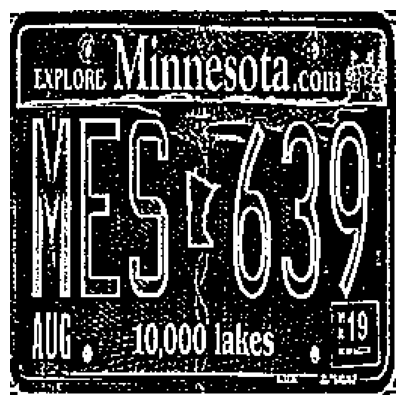

In [28]:
import matplotlib.pyplot as plt
for i in range(1):
  plt.figure(figsize=(7, 5))
  plt.imshow(train_images_a[i], cmap='gray')
  plt.axis('off')
  plt.savefig('Car-Adaptive-Thresholding.png',bbox_inches = 'tight')
  plt.show()

In [6]:
from keras.preprocessing.image import ImageDataGenerator

def paired_generator(images_a, images_b, labels, batch_size):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Create two generators for images_a and images_b
    gen_a = datagen.flow(images_a, labels, batch_size=batch_size, seed=1, shuffle=False)
    gen_b = datagen.flow(images_b, labels, batch_size=batch_size, seed=1, shuffle=False)

    while True:
        batch_a = gen_a.next()
        batch_b = gen_b.next()

        yield [batch_a[0], batch_b[0]], batch_a[1]


In [37]:
batch_size = 32  # Or any other preferred batch size

train_gen = paired_generator(train_images_a, train_images_b, yTrain_encoded, batch_size)
validation_gen = paired_generator(test_images_a, test_images_b, yTest_encoded, batch_size)

steps_per_epoch = len(train_images_a) // batch_size
validation_steps = len(test_images_a) // batch_size



In [7]:
def generate_triplets(dataset, labels, num_triplets=1000):
    """
    Generate a list of anchor, positive and negative images for training.
    dataset : list of loaded images in form of numpy arrays
    labels : list of labels corresponding to images in the dataset
    num_triplets : number of triplets you want to generate
    """

    anchor_images = np.zeros((num_triplets, 128, 128, 1))
    positive_images = np.zeros((num_triplets, 128, 128, 1))
    negative_images = np.zeros((num_triplets, 128, 128, 1))

    for i in range(0, num_triplets):
        # Pick a random anchor
        random_index = np.random.randint(0, len(labels))
        anchor = dataset[random_index]
        anchor_label = labels[random_index]

        # Get a positive sample
        indices_for_pos = np.squeeze(np.where(labels == anchor_label))
        indices_for_neg = np.squeeze(np.where(labels != anchor_label))

        positive = dataset[np.random.choice(indices_for_pos)]

        # Get a negative sample
        negative = dataset[np.random.choice(indices_for_neg)]

        anchor_images[i] = anchor
        positive_images[i] = positive
        negative_images[i] = negative

    return anchor_images, positive_images, negative_images


In [8]:
def create_triplets_from_pairs(positive_pairs, negative_pairs):
    triplets = []
    for pos_pair in positive_pairs:
        anchor, positive, _ = pos_pair
        # choose a random negative example
        _, negative, _ = random.choice(negative_pairs)
        triplets.append((anchor, positive, negative))
    return triplets

triplets = create_triplets_from_pairs(selected_positive_pairs, selected_negative_pairs)


In [9]:
anchors = [triplet[0] for triplet in triplets]
positives = [triplet[1] for triplet in triplets]
negatives = [triplet[2] for triplet in triplets]
y_dummy = np.zeros((len(anchors),))

anchors_images = [img for img in load_and_preprocess_images(anchors) if img is not None]

positives_images = [img for img in load_and_preprocess_images(positives) if img is not None]

negatives_images = [img for img in load_and_preprocess_images(negatives) if img is not None]

positives_images = np.array(anchors_images).reshape(-1, size[0], size[1], 1)  # reshaped since the images are grayscale

negatives_images = np.array(negatives_images).reshape(-1, size[0], size[1], 1)

anchors_images = np.array(anchors_images).reshape(-1, size[0], size[1], 1)


100%|██████████| 2000/2000 [00:05<00:00, 384.71it/s]


In [12]:
model.fit([anchors_images, positives_images, negatives_images], y_dummy, epochs=3, batch_size=32)

Epoch 1/3


ValueError: ignored

In [ ]:
all_anchors, all_positives, all_negatives = generate_triplets(pair_, dataset_labels, 10000)

# Split into train and validation (assuming you have a method to split data)
train_anchors, val_anchors, train_positives, val_positives, train_negatives, val_negatives = split_data(all_anchors, all_positives, all_negatives)


In [18]:
# Create the base network
input_shape = (256, 256, 1)
base_network = create_base_network(input_shape)

# Create the triplet network
triplet_model = create_triplet_model(base_network, input_shape)

# Compile
triplet_model.compile(optimizer='adam', metrics=['accuracy'], loss=triplet_loss)

# Dummy labels: y_train. Its shape should match the number of triplets. The values don't matter because they're not actually used in the loss.
y_dummy = np.empty((len(anchors_images),))

# Training
triplet_model.fit([anchors_images, positives_images, negatives_images], y_dummy, epochs=50)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/constant_op.py:103: RuntimeWarning: overflow encountered in cast
  return ops.EagerTensor(value, ctx.device_name, dtype)


63/63 [==============================] - 49s 749ms/step - loss: 4.1160e-05 - accuracy: 0.0000e+00
Epoch 2/50
20/63 [========>.....................] - ETA: 32s - loss: 0.0000e+00 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored

In [11]:
model = Model([input_a, input_b], prediction)
#model.compile(loss=K.binary_crossentropy, optimizer='adam', metrics=['accuracy'])
from keras.metrics import Precision, Recall

model.compile(optimizer='adam',
              loss=K.binary_crossentropy,
              metrics=['accuracy', Precision(), Recall()])


In [82]:
model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=3,
    validation_data=validation_gen,
    validation_steps=validation_steps
)


Epoch 1/3
75/75 [==============================] - 53s 686ms/step - loss: 0.6960 - accuracy: 0.4996 - precision_9: 0.5025 - recall_9: 0.9810 - val_loss: 0.6933 - val_accuracy: 0.4812 - val_precision_9: 0.4812 - val_recall_9: 1.0000
Epoch 2/3
75/75 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.5075 - precision_9: 0.5065 - recall_9: 0.9918

KeyboardInterrupt: ignored

In [ ]:
model.fit([train_images_a, train_images_b], yTrain_encoded, validation_data=([test_images_a, test_images_b], yTest_encoded), epochs=3, batch_size=64, metrics=['accuracy'])


In [44]:
distances = model.predict([val_images_a, val_images_b])

25/25 [==============================] - 6s 225ms/step


In [60]:
# Print out the distances
from keras.layers import Activation
min_distance = np.min(distances)
max_distance = np.max(distances)

normalized_distances = (distances - min_distance) / (max_distance - min_distance)
thresholded_distances = np.where(normalized_distances <= 0.8, 1, 0)

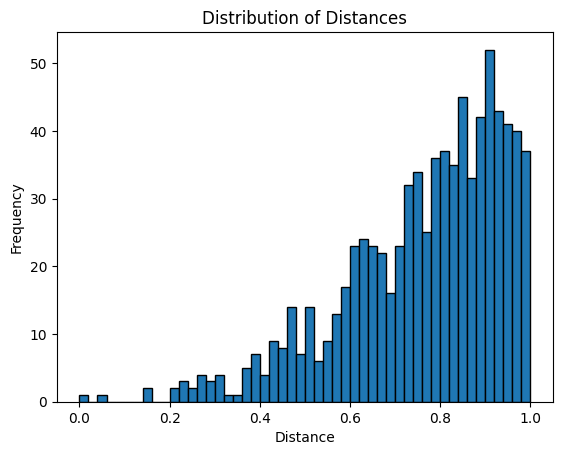

In [61]:
plt.hist(normalized_distances, bins=50, edgecolor='black')
plt.title("Distribution of Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

In [62]:
# Generate thresholds
num_thresholds = 100
thresholds = np.linspace(0, 1, num_thresholds)

# Initialize variables for optimal threshold and corresponding metric
best_f1 = 0
optimal_threshold = 0

# Iterate over thresholds and compute evaluation metrics
j = 0
for threshold in thresholds:
    # Convert probabilities into class labels based on threshold
    predicted_labels = thresholded_distances

    # Calculate evaluation metric (e.g., F1-score) using the true labels (y_test) and predicted labels
    f1 = f1_score(yVal_encoded, predicted_labels)
    j += 1
    # Update optimal threshold and metric if a higher F1-score is achieved
    if f1 > best_f1:
        best_f1 = f1
        optimal_threshold = threshold

print("Optimal Threshold:", optimal_threshold)
print("Best F1-score:", best_f1)


Optimal Threshold: 0.0
Best F1-score: 0.4893350062735257


In [59]:
print(thresholded_distances.sum())

78


In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

accuracy = accuracy_score(yVal_encoded, thresholded_distances)
precision = precision_score(yVal_encoded, thresholded_distances)
recall = recall_score(yVal_encoded, thresholded_distances)
f1 = f1_score(yVal_encoded, thresholded_distances)
auroc = roc_auc_score(yVal_encoded, thresholded_distances)
print('Acc:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUROC Score:', auroc)

Acc: 0.49125
Precision: 0.4936708860759494
Recall: 0.48507462686567165
F1 Score: 0.4893350062735257
AUROC Score: 0.49128103202580065


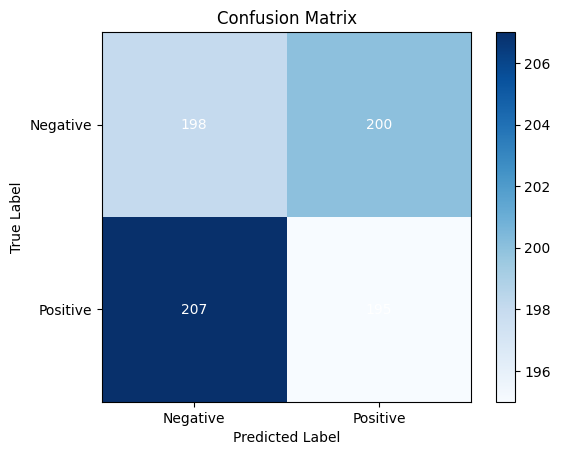

In [64]:
# Calculate confusion matrix
cm = confusion_matrix(yVal_encoded, thresholded_distances)

# Define class labels
class_labels = ['Negative', 'Positive']

# Create labeled confusion matrix plot
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

# Add labels to each cell
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

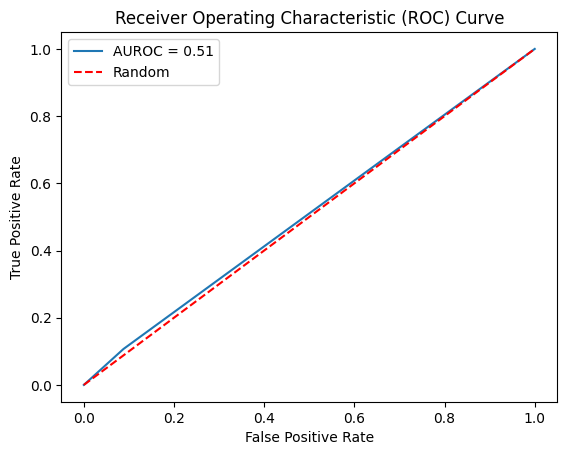

In [56]:
# Assuming 'y_true' contains the true labels and 'y_scores' contains the predicted scores or probabilities
fpr, tpr, thresholds = roc_curve(yVal_encoded, thresholded_distances)

# Calculate the AUROC score
auroc = roc_auc_score(yVal_encoded, thresholded_distances)

# Plot the AUROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [137]:
# Assuming you have test_pairs as your set of test image pairs
testP = '/content/drive/MyDrive/LicensePlate/license'
testD = create_metadata(data_path)
test = [os.path.join(testP, img) for img in os.listdir(testP) if img.endswith(('.png', '.jpg', '.jpeg'))]
all_pairs = []
for i in range(len(test)):
    for j in range(i+1, len(test)):
        all_pairs.append((test[i], test[j]))

val_images_a_paths = [pair[0] for pair in all_pairs]
val_images_b_paths = [pair[1] for pair in all_pairs]

testA = [img for img in load_and_preprocess_images(val_images_a_paths) if img is not None]
testB = [img for img in load_and_preprocess_images(val_images_b_paths) if img is not None]

testA = np.array(testA).reshape(-1, size[0], size[1], 1)  # reshaped since the images are grayscale
testB = np.array(testB).reshape(-1, size[0], size[1], 1)


100%|██████████| 4950/4950 [00:06<00:00, 763.16it/s]


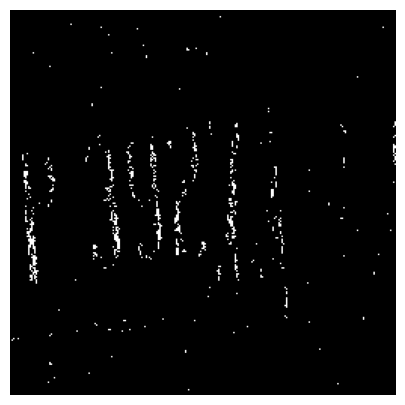

In [21]:
for i in range(1):
  plt.figure(figsize=(7, 5))
  plt.imshow(testB[i], cmap='gray')
  plt.axis('off')
  plt.savefig('Car-Adaptive-Thresholding.png',bbox_inches = 'tight')
  plt.show()

In [22]:
distances = model.predict([testA, testB])

155/155 [==============================] - 36s 233ms/step


In [ ]:
print(distances)

In [23]:
# Print out the distances
from keras.layers import Activation
min_distance = np.min(distances)
max_distance = np.max(distances)

normalized_distances = (distances - min_distance) / (max_distance - min_distance)
thresholded_distances = np.where(normalized_distances <= 0.2, 1, 0)

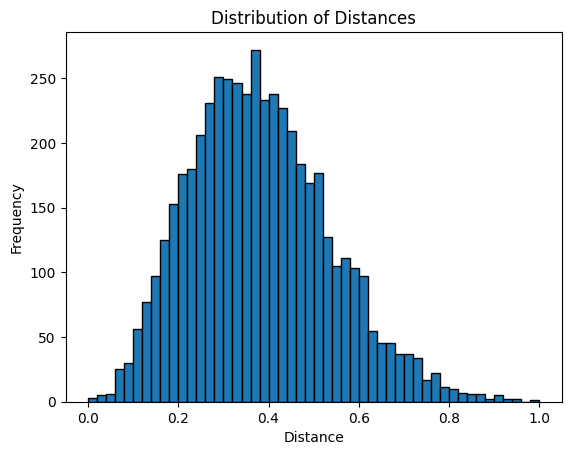

In [24]:
plt.hist(normalized_distances, bins=50, edgecolor='black')
plt.title("Distribution of Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

In [67]:
print(thresholded_distances)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


# YOLO

In [ ]:
import os

import numpy as np
import cv2
import uuid
import time
import pandas as pd

import xmltodict
import glob
import xml.etree.ElementTree as ET
import random as rnd
import splitfolders
import easyocr
import PIL
import copy

from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image
from tqdm.auto import tqdm
from GPUtil import showUtilization as gpu_usage
from numba import cuda
from timeit import default_timer as timer

import torch

import matplotlib
matplotlib.use('TkAgg')

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib import patches as mpatches

In [ ]:
dataset = {
            "file":[],
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],
            "xmax":[],
            "ymax":[]
           }

In [ ]:
img_names=[]
annotations=[]
for dirname, _, filenames in os.walk("kaggle/CV/Plate_recognition/"):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]==("png" or "jpg"):
            img_names.append(filename)
        elif os.path.join(dirname, filename)[-3:]=="xml":
            annotations.append(filename)

img_names[:10]

# Siamese 1

In [2]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics import pairwise_distances
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

from itertools import combinations



KeyboardInterrupt: ignored

In [ ]:
folder_path = '/content/drive/MyDrive/LicensePlate/states'  # Replace this with the path to your folder
folder_pathTest = '/content/drive/MyDrive/LicensePlate/license'
states = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado",
    "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois",
    "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland",
    "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana",
    "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York",
    "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania",
    "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah",
    "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
]
# Get list of all image paths
image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
image_pathsTest = [os.path.join(folder_pathTest, img) for img in os.listdir(folder_pathTest) if img.endswith(('.png', '.jpg', '.jpeg'))]

input_shape = (64, 64)

def load_and_preprocess_images(image_paths, target_size=input_shape):
    images = []
    for path in image_paths:
        try:
            img = load_img(path, target_size=target_size)
            img_array = img_to_array(img)
            images.append(img_array)
        except Exception as e:
            print(f"Error processing image {path}. Error: {e}")
            if os.path.exists(path):
                os.remove(path)
                print(f"File {path} has been deleted!")
            else:
                print(f"File {path} not found!")
    return np.array(images) / 255.0  # Normalize

def generate_pairs_and_labels(subset_image_paths, matching_pairs):
    pairs = []
    labels = []

    for pair in matching_pairs:
        idx1 = subset_image_paths.index.get_loc(pair[0])
        idx2 = subset_image_paths.index.get_loc(pair[1])
        pairs.append([pair[0], pair[1]])
        labels.append(1)  # 1 indicates that the pair is similar

    return np.array(pairs), np.array(labels)


""" Go through and label which states are which """
plates = pd.DataFrame({'paths': sorted(image_paths), 'states': states})
# Split paths for train and test first
#train_images, test_images = train_test_split(plates, test_size=0.2, random_state=42)
XTrain = plates['paths']
yTrain = plates['states']
XTest = image_pathsTest
# Load images
"""train_images = load_and_preprocess_images(train_image_paths)
test_images = load_and_preprocess_images(test_image_paths)"""

# For this example, we're generating matching pairs for all images.
# In practice, you'd want a more specific criteria for determining matches.
train_matching_pairs = list(combinations(XTrain, 2))
test_matching_pairs = list(combinations(XTest, 2))

# Generate pairs and labels
train_pairs, train_labels = generate_pairs_and_labels(XTrain, train_matching_pairs)
test_pairs, test_labels = generate_pairs_and_labels(XTest, test_matching_pairs)

In [ ]:
model = VGG16(weights='imagenet', include_top=False)

def get_image_features(model, train_images):
    preprocessed_images = preprocess_input(train_images)
    features = model.predict(preprocessed_images)
    return features.reshape(features.shape[0], -1)
features = get_image_features(model, train_images)


In [ ]:
distances = pairwise_distances(features)
print(distances)

In [ ]:
threshold = 2  # You need to adjust this based on your needs; smaller values make the matching stricter

matching_pairs = []

for i in range(distances.shape[0]):
    for j in range(i+1, distances.shape[0]):
        if distances[i][j] < threshold:
            matching_pairs.append((image_paths[i], image_paths[j]))

"""for pair in matching_pairs:
    print(f"Matching pair: {pair[0]} and {pair[1]}")"""


In [ ]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Conv2D(128, (7,7), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    return Model(input, x)

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

input_shape = (64, 64, 3)
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Use the constructed CNN above for both inputs
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance)([processed_a, processed_b])

siamese_net = Model([input_a, input_b], distance)


In [ ]:
input_1_train = train_pairs[:, 0]
input_2_train = train_pairs[:, 1]

input_1_test = test_pairs[:, 0]
input_2_test = test_pairs[:, 1]

siamese_net.compile(optimizer='adam', loss='mean_squared_error')

# Train the Siamese network using train pairs and validate using test pairs
history = siamese_net.fit([input_1_train, input_2_train], train_labels,
                          validation_data=([input_1_test, input_2_test], test_labels),
                          epochs=3, batch_size=2)


In [ ]:
test_input_1 = test_pairs[:, 0]
test_input_2 = test_pairs[:, 1]
test_loss = siamese_net.evaluate([test_input_1, test_input_2], test_labels)
print("Test loss:", test_loss)


# Number Detection

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd



import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

In [ ]:
plates.head()

# CNN

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
tr = np.array(train_images).reshape(-1, 64, 64, 1)
te = np.array(test_images).reshape(-1, 64, 64, 1)
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(tr, train_labels, epochs=3, batch_size=32, validation_data=(te, test_labels))

# Predict
predictions = model.predict(test_images)
predicted_states = [states[np.argmax(pred)] for pred in predictions]


ValueError: ignored

In [21]:
print((yTrain_encoded).sum())

177933.0


In [ ]:
from pandas.core.arrays.timedeltas import precision_from_unit
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Evaluate the model
acc = accuracy_score(test_labels, predicted_states)
rec = recall_score(test_labels, predicted_states, average='macro')
prec = precision_from_unit(rec, precision_from_unit(acc, recall_score(test_labels, predicted_states, average='macro')))
f1 = f1_score(test_labels, predicted_states, average='macro')
auroc = roc_auc_score(test_labels, predictions, multi_class='ovo')

print('Accuracy:' , acc)
print('Recall:' , rec)
print('Precision:' , prec)
print(f'F1: {f1}')
print(f'AUROC: {auroc}')




In [ ]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
cm = confusion_matrix(test_labels, predicted_states)


# Numbers

In [ ]:
pip install pytesseract

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract                # Pytesseract, OCR (matn tanishuvchi) funksiyalarini bajarish uchun kuchli kutubxonadir.
from PIL import Image
plt.style.use('dark_background')

In [ ]:
pic = cv2.imread('/content/drive/MyDrive/LicensePlate/archive/data/Alabama/0d16579f591cf8.jpg')



height, width, channel = pic.shape

plt.figure(figsize=(12, 10))
plt.imshow(pic, cmap='gray')
plt.axis('on')
plt.savefig('Car.png',bbox_inches = 'tight')
plt.show()

In [ ]:
gray = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)    # kulrangga o'tkazadi'

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('Car-GrayScale.png',bbox_inches = 'tight')
plt.show()

In [ ]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))    # Har bir pixelga ishlov berish uchun

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)     #yorqin
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)    #qora

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)           # Yorqinni qo'shamiz
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)     # qorani ayiramiz

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('Car-Contrast.png',bbox_inches = 'tight')
plt.show()

In [ ]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)  #Gauss filtri

img_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,     #adaptiv metod bilan ajratiladi.
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')
plt.axis('off')
plt.savefig('Car-Adaptive-Thresholding.png',bbox_inches = 'tight')
plt.show()

In [ ]:
contours, _= cv2.findContours(
    img_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)
plt.axis('off')
plt.savefig('Car-Contours.png',bbox_inches = 'tight')
plt.show()

In [ ]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)

    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('Car-Boxes.png',bbox_inches = 'tight')
plt.show()

In [ ]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('Car-Boxes-byCharSize.png',bbox_inches = 'tight')
plt.show()

In [ ]:
MAX_DIAG_MULTIPLYER = 5 # 5
MAX_ANGLE_DIFF = 12.0 # 12.0
MAX_AREA_DIFF = 0.5 # 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3 # 3

def find_chars(contour_list):
    matched_result_idx = []

    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)

        # recursive
        recursive_contour_list = find_chars(unmatched_contour)

        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('Car-Boxes-byContourArrangement.png',bbox_inches = 'tight')
plt.show()

In [ ]:

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(pic, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(pic, cmap='gray')
plt.axis('off')
plt.savefig('Car-OverlappingBoxes.png',bbox_inches = 'tight')
plt.show()

In [ ]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)

    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) -
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )

    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)

    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))

    img_cropped = cv2.getRectSubPix(
        img_rotated,
        patchSize=(int(plate_width), int(plate_height)),
        center=(int(plate_cx), int(plate_cy))
    )

    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue

    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })

    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')
    plt.axis('off')
    plt.savefig('Car-Plates(Rotated).png',bbox_inches = 'tight')
    plt.show()

In [ ]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h

    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]

    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')
    plt.axis('off')
    plt.savefig('Car-Plates(Thresholding).png',bbox_inches = 'tight')
    plt.show()


In [ ]:
img = 255-img_result
plt.imshow(img, 'gray')
plt.axis('off')
plt.savefig('Car-Plates(Negative).png',bbox_inches = 'tight')
plt.show()
#border is black because remember i set the background to be black

# CRNN

In [34]:
pair_labels[3]

1

In [29]:
all_characters = sorted(set(''.join(data["labels"].astype(str).tolist())))
char_to_num = {char: i for i, char in enumerate(all_characters)}
num_to_char = {i: char for char, i in char_to_num.items()}
print(num_to_char)

{0: 'A', 1: 'C', 2: 'D', 3: 'F', 4: 'G', 5: 'H', 6: 'I', 7: 'J', 8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'O', 13: 'P', 14: 'R', 15: 'S', 16: 'T', 17: 'U', 18: 'V', 19: 'W', 20: 'Y', 21: 'a', 22: 'b', 23: 'c', 24: 'd', 25: 'e', 26: 'f', 27: 'g', 28: 'h', 29: 'i', 30: 'k', 31: 'l', 32: 'm', 33: 'n', 34: 'o', 35: 'p', 36: 'r', 37: 's', 38: 't', 39: 'u', 40: 'v', 41: 'w', 42: 'x', 43: 'y', 44: 'z'}


In [58]:
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, Dropout, LSTM, Bidirectional, Dropout, BatchNormalization
from keras.models import Model

def build_crnn_model(input_shape, num_classes):
    image_input = Input(shape=input_shape, name='the_input')
    labels = Input(name='the_labels', shape=[None], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    # Convolution block 1
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Convolution block 2
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Convolution block 3
    x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Prepare RNN inputs
    rnn_input_shape = (input_shape[0] // 8, input_shape[1] // 8 * 128)
    x = Reshape(target_shape=rnn_input_shape)(x)
    x = Dense(128, activation="relu")(x)

    # RNN layers
    x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.25))(x)
    x = LSTM(256, return_sequences=True, dropout=0.25)(x)
    x = LSTM(256, return_sequences=True, dropout=0.25)(x)

    # Final dense layer
    x = Dense(num_classes, activation="softmax", name="output")(x)

    ctc_layer = CTCLayer(name='ctc_output')
    output = ctc_layer(labels, x)

    model = Model(inputs=[image_input, labels, input_length, label_length], outputs=output)
    return model

In [59]:
import tensorflow as tf
from keras.layers import Layer

class CTCLayer(Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Ensure y_true and y_pred are the expected shapes
        y_true = tf.ensure_shape(y_true, (None, None))
        y_pred = tf.ensure_shape(y_pred, (None, None, None))

        # Assuming that y_pred has shape (batch_size, sequence_length, num_classes)
        input_length = tf.shape(y_pred)[1] * tf.ones(shape=(tf.shape(y_pred)[0], 1), dtype=tf.int32)

        # Assuming y_true has shape (batch_size, sequence_length)
        label_length = tf.reduce_sum(tf.cast(tf.math.not_equal(y_true, -1), tf.int64), axis=-1, keepdims=True)

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # Return y_pred to ensure the layer's output is of the expected shape
        return y_pred



In [62]:
import cv2
import numpy as np
import random

def data_generator(data_sample, char_to_num, batch_size=32):
    while True:
        # Select batch_size number of samples randomly
        batch_samples = random.sample(data_sample, batch_size)

        # Create empty containers for the batch
        batch_images = []
        batch_labels = []
        batch_input_lengths = []
        batch_label_lengths = []

        # Process each sample in the batch
        for sample in batch_samples:
            image_path = sample['image_paths']
            label_text = sample['labels']

            # Read and preprocess the image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (128, 32))
            img_blurred = cv2.GaussianBlur(image, ksize=(3, 3), sigmaX=0)  #Gauss filtri

            img_thresh = cv2.adaptiveThreshold(
                img_blurred,
                maxValue=255.0,
                adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,     #adaptiv metod bilan ajratiladi.
                thresholdType=cv2.THRESH_BINARY_INV,
                blockSize=5,
                C=2
            )
            image = np.expand_dims(img_thresh, axis=-1)
            batch_images.append(image)

            # Encode the label
            label = [char_to_num[char] for char in label_text]
            batch_labels.append(label)

            # Add input length (assuming CRNN model architecture and the use of a single LSTM layer)
            batch_input_lengths.append(4)

            # Add label length
            batch_label_lengths.append(len(label))

        # Paddings for labels so they all have the same length
        max_label_len = max([len(label) for label in batch_labels])
        pad_labels = np.ones((batch_size, max_label_len)) * -1
        for i, label in enumerate(batch_labels):
            pad_labels[i, :len(label)] = label

        batch_images = np.array(batch_images, dtype=np.float32) / 255

        inputs = {
            'the_input': batch_images,
            'the_labels': pad_labels,
            'input_length': np.array(batch_input_lengths),
            'label_length': np.array(batch_label_lengths),
        }

          # Outputs for the CTC loss function
        outputs = {'ctc_output': np.zeros([batch_size])}
        yield inputs, outputs


In [63]:
input_shape = (128, 32, 1)  # height, width, channels
dataSample = data.sample(n=len(data), random_state=42).reset_index(drop=True)
num_classes = len(char_to_num) + 1  # +1 for CTC 'blank' character
labels = []
labels = [[char_to_num[char] for char in label_string] for label_string in dataSample['labels']]
model = build_crnn_model(input_shape, num_classes)
model.compile(optimizer='adam', metrics=[])

# You might need to pad the sequences, using something like:
labels = tf.keras.preprocessing.sequence.pad_sequences(labels, padding='post')



ValueError: ignored

In [46]:
from sklearn.model_selection import train_test_split

data_list = dataSample[['image_paths', 'labels']].to_dict('records')

# Split the data_list into training and validation sets (e.g., 80% train, 20% validation)
train_data, val_data = train_test_split(data_list, test_size=0.2, random_state=42)

batch_size = 32
train_steps_per_epoch = len(train_data) // batch_size
val_steps_per_epoch = len(val_data) // batch_size

# Create the two generators
train_gen = data_generator(train_data, char_to_num, batch_size=batch_size)
val_gen = data_generator(val_data, char_to_num, batch_size=batch_size)

# Test the generators
train_inputs, train_outputs = next(train_gen)
val_inputs, val_outputs = next(val_gen)


In [48]:
# For training:
model.fit(train_inputs, train_outputs,
          validation_data=(val_inputs, val_outputs),
          epochs=3,
          steps_per_epoch=train_steps_per_epoch,
          validation_steps=val_steps_per_epoch)

Epoch 1/3
 96/112 [========================>.....] - ETA: 1s - loss: 24.8618

112/112 [==============================] - 30s 272ms/step - loss: 24.8618 - val_loss: 25.9653


In [49]:
testP = '/content/drive/MyDrive/LicensePlate/license'
test = [os.path.join(testP, img) for img in os.listdir(testP) if img.endswith(('.png', '.jpg', '.jpeg'))]

def load_and_preprocess_image(img_path):
    # Load image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        return None

    # Resize to the desired size (e.g., (128, 32))
    img = cv2.resize(img, (128, 32))

    # Normalize the image
    img = img / 255.0

    # Expand dimensions (channels)
    img = np.expand_dims(img, axis=-1)  # Add channel dimension

    return img

testI = [load_and_preprocess_image(img_path) for img_path in test]
testI = [img for img in testI if img is not None]

# Convert list of arrays into a single array
testF = np.stack(testI, axis=0)  # This combines all the preprocessed images into a single batch

print(test)

['/content/drive/MyDrive/LicensePlate/license/00000fce920521f5da4e687bb4cdd5a8.jpg', '/content/drive/MyDrive/LicensePlate/license/00016fc5bbc159d2a89b4f89febf843b.jpg', '/content/drive/MyDrive/LicensePlate/license/00019c99560089e568cb1e71b0e4fb88.jpg', '/content/drive/MyDrive/LicensePlate/license/0001a5dcaa98b89ddaed2d4b0e6b9a34.jpg', '/content/drive/MyDrive/LicensePlate/license/0003059abef2ba5a2cae8adda0ac9c27.jpg', '/content/drive/MyDrive/LicensePlate/license/00036ac1b7f7c779c25e9fff217c922f.jpg', '/content/drive/MyDrive/LicensePlate/license/000349b8869928df1464043fb2a9fdaa.jpg', '/content/drive/MyDrive/LicensePlate/license/000113376e0aa14315b9f7f95a304c4f.jpg', '/content/drive/MyDrive/LicensePlate/license/00017dbbfd06acdf7e5c68d14584f336.jpg', '/content/drive/MyDrive/LicensePlate/license/0001aef607466205d35b37920635d430.jpg', '/content/drive/MyDrive/LicensePlate/license/000203af2be69e79fde1c9e3b2381f87.jpg', '/content/drive/MyDrive/LicensePlate/license/00027f6e43a693136c738196831f69

In [51]:
def create_test_metadata(data_path):
    image_paths = []

    for img_name in os.listdir(data_path):
        full_path = os.path.join(data_path, img_name)
        if os.path.isfile(full_path):
            image_paths.append(full_path)

    return pd.DataFrame({'image_paths': image_paths, 'labels': [''] * len(image_paths)})

def test_data_generator(data_sample, char_to_num, batch_size):
    while True:
        batch_samples = random.sample(data_sample, batch_size)
        batch_images = []

        for sample in batch_samples:
            image_path = sample['image_paths']

            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (128, 128))
            img_blurred = cv2.GaussianBlur(image, ksize=(3, 3), sigmaX=0)  #Gauss filtri
            img_thresh = cv2.adaptiveThreshold(
                img_blurred,
                maxValue=255.0,
                adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,     #adaptiv metod bilan ajratiladi.
                thresholdType=cv2.THRESH_BINARY_INV,
                blockSize=5,
                C=2
            )
            image = np.expand_dims(img_thresh, axis=-1)
            batch_images.append(image)

        batch_images = np.array(batch_images, dtype=np.float32) / 255

        yield batch_images



dataTest = create_test_metadata(testP)
steps_per_epoch = len(test) // batch_size
dataTest_list = dataTest.to_dict('records')
test_gen = test_data_generator(dataTest_list, char_to_num, batch_size=batch_size)
inputs = next(test_gen)

def prediction_model(original_model):
    return Model(inputs=original_model.get_layer(name='the_input').input,
                 outputs=original_model.get_layer(name='output').output)

pred_model = prediction_model(model)
raw_predictions = pred_model.predict(inputs)
decoded_predictions = tf.keras.backend.ctc_decode(raw_predictions, input_length=np.ones(raw_predictions.shape[0])*raw_predictions.shape[1], greedy=True)[0][0]

1/1 [==============================] - 1s 1s/step


In [191]:
print(dataTest)

Empty DataFrame
Columns: [image_paths, labels]
Index: []


In [176]:
print(test_gen)

<generator object data_generator at 0x7a16ac3c0a50>


In [175]:
# Assuming you have the batch size
batch_size = testF.shape[0]

# Prepare dummy inputs for other tensors (using arbitrary values)
dummy_labels = np.ones([batch_size, 1])
dummy_input_length = np.ones([batch_size, 1]) * 32  # Use appropriate value
dummy_label_length = np.ones([batch_size, 1])

# Use model.predict to get raw predictions
raw_predictions = model.predict([testF, dummy_labels, dummy_input_length, dummy_label_length])


TypeError: ignored

In [1]:
from tensorflow import keras

crnn_model = keras.Model(inputs=model.input[0], outputs=model.get_layer('output').output)


NameError: ignored

In [ ]:
raw_predictions = crnn_model.predict(inputs)


In [252]:
decoded_predictions = tf.keras.backend.ctc_decode(raw_predictions, input_length=np.ones(raw_predictions.shape[0])*raw_predictions.shape[1], greedy=True)[0][0]


In [56]:
def decode_predictions(predictions):
    decoded_texts = []
    for prediction in predictions:
        text = ''
        for idx in prediction:
            if idx == -1:  # CTC might return -1 indicating no more characters
                break
            text += num_to_char[idx]
        decoded_texts.append(text)
    return decoded_texts

decoded_texts = decode_predictions(decoded_predictions.numpy())  # Convert tensors to numpy arrays before passing
print(decoded_texts)


['Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me', 'Me']


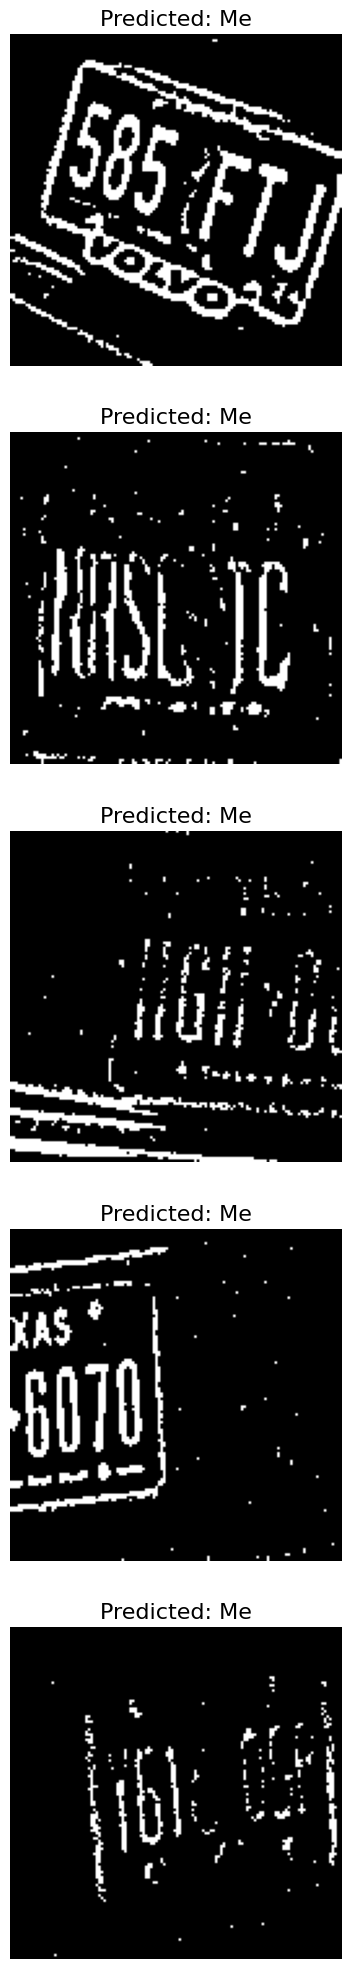

In [57]:
import matplotlib.pyplot as plt

def visualize_predictions(images, decoded_predictions, num_samples=5):
    """
    Display images alongside their predictions.

    Parameters:
    - images: List of preprocessed images
    - decoded_predictions: List of decoded prediction strings
    - num_samples: Number of samples to display
    """
    fig, axes = plt.subplots(num_samples, 1, figsize=(20, 5 * num_samples))

    for ax, image, prediction in zip(axes, images[:num_samples], decoded_predictions[:num_samples]):
        ax.imshow(image.squeeze(), cmap='gray')  # If your images are grayscale
        ax.set_title(f"Predicted: {prediction}", fontsize=16)
        ax.axis('off')

    plt.show()

visualize_predictions(inputs, decoded_texts)  # Assuming 'decoded_predictions' is the list of decoded prediction strings
